<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/drift_sampling_0813.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drift를 측정하기 위한 sampling의 방법

# Abstract

* 현실 세계의 data (예:대출에 대한 default 예측)는 개별적으로는 시간 요소가 고려되지 않는 time-series 가 아니며, iid(independent and identically distribution) 이라고 할 수 있느나, 장시간으로 보면 시간에 따라 data의 distribution이 변하는 (drift) '시간 요소를 포함 한다' 할 수 있다. 이런 data는 시간에 따라 변화 하는 현실 세계의 변수를 모두 포함 할 수 없기 때문에 non-time-series 이며 iid 이지만 '시간 요소를 포함 한다' 라고 표현 할 수 있다.
* 이러한 data를 '시간의 영향을 받는 데이터 (Time Affected Data)' 라고 명명하고, 간략히 TAD 라고 하자.
* TAD의 중요한 통계량은 drift 통계량인데, 그렇다면 TAD의 drift 모수 추정은 어떻게 할 수 있는가?
* 이 주제의 중요성은 많은 인공지능 모델들의 대상 데이터가 사실은 TAD의 특성을 갖고 있으며, 그렇다면 모델의 성능은 영속적으로 유지 되지 않는다는 것이다.
* 즉, TAD의 drift 모수 추정이 가능하다면 TAD를 대상으로 하는 모델의 성능을 추정할 수 있는 것이다.
* 일반적인 iid(independent and identically distribution) data의 경우, random sampling에 해당하는 bootstrap sampling에 의해 모수 추정이 가능한다. TAD의 경우도 bootstrap sampling에 의해 drift 모수 추정이 가능할까? 만약 그렇지 않다면, 어떤 sampling 기법을 적용하여야 하는가?
* 본, 연구의 주제이다.

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random
np.random.seed(1337)

In [3]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

<ipython-input-3-9b4d5ff8fbde>:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")


(2260701, 151)


In [4]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:

df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

# maybe we can go further, and eliminate columns up to title:

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():

df_accepted = df_accepted.dropna()
df_accepted.shape

# These are constant columns. We can drop it either.

cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])

# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
df_accepted.shape

df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])

X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns



(1345310, 151)
n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


<ipython-input-4-55a65e7a1f3d>:115: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()


2010
2011
2012
2013
2014
2015
2016
2017
2018


In [5]:
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

<Axes: >

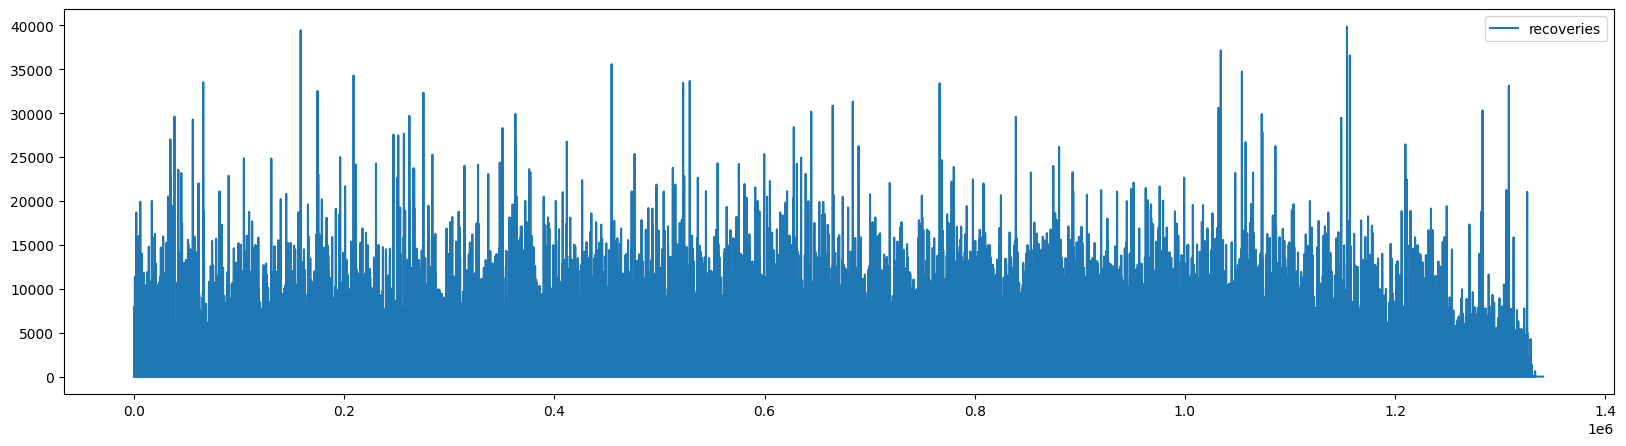

In [6]:
df_accepted['recoveries'].plot(legend=True, figsize=(20,5))

<Axes: >

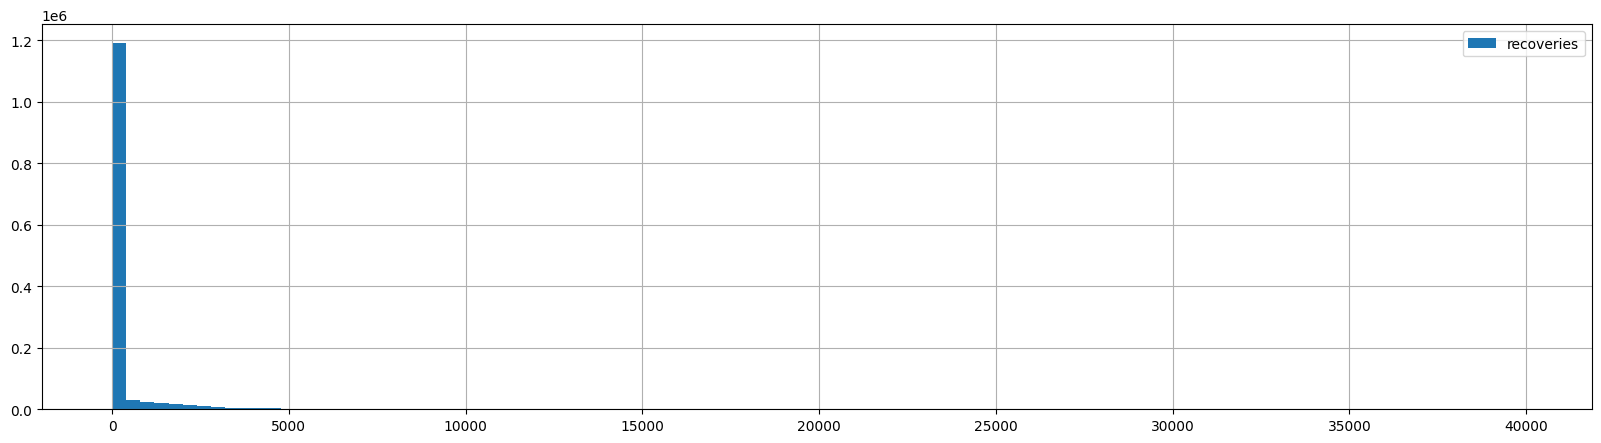

In [7]:
df_accepted['recoveries'].hist(bins=100,legend=True, figsize=(20,5))

In [8]:
X[2009][:,15]

array([1910.03,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ])

In [9]:
mean_recoveries = np.mean(df_accepted['recoveries'].values)

In [10]:
mean_recoveries

239.50665637282694

* 'recoveries' 의 평균값은 239.50, 으로 이는 모수에 해당.

In [15]:
pop = list(df_accepted['recoveries'].values)

sample_mean = []
for i in range(1000):
  y = random.sample(pop,1000)
  avg = np.mean(y)
  sample_mean.append(avg)

print(np.mean(sample_mean),np.std(sample_mean))

239.93244040304884 30.64269676066815


In [13]:
pop = list(df_accepted['recoveries'].values)
pop = np.asarray(pop)
sample_mean = []
for i in range(int(pop.shape[0]/1000)):
  y =  pop[i*1000:i*1000+1000] #random.sample(pop,1000)
  avg = np.mean(y)
  sample_mean.append(avg)

print(np.mean(sample_mean),np.std(sample_mean))

239.51130005147402 66.85014647261697


* bootstrap sampling 1000개 1000번으로 평균 239.32, 표준편차 30.31의 매우 근접한 통계량을 얻었다.

In [16]:
from scipy.stats import ks_2samp, kstest
pops = []
for i in range(0,len(pop),1000):
    pops.append(pop[i:i+1000])

In [17]:
sample_drift = []
for pp in pops:
    #p = ks_2samp(random.sample(pop,1000),pp)
    p = ks_2samp(pops[0],pp)
    sample_drift.append(p[0])

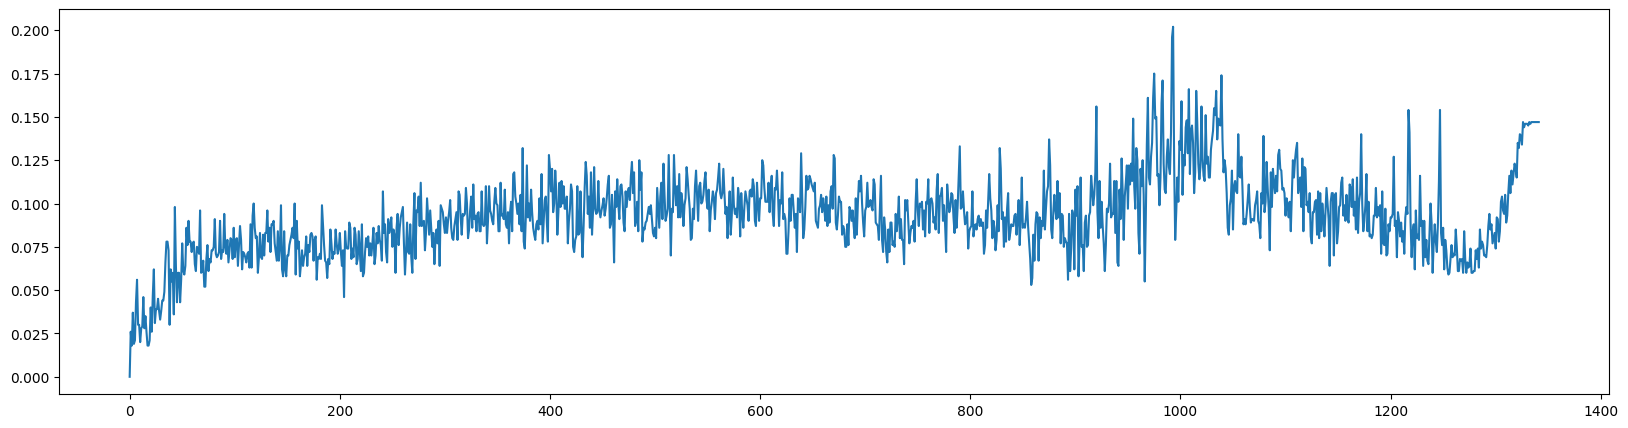

In [18]:
plt.figure(figsize=(20,5))
plt.plot(sample_drift)

In [19]:
print(np.mean(sample_drift),np.std(sample_drift))

0.0926892697466468 0.022963416533055458


* 'recoveries'의 ks-test에 대한 (최초 1000개 기준, 1000개 Two-sample Kolmogorov–Smirnov test) drift 통계량은 0.0926, drift의 표준편차는 0.0229

In [20]:
sample_drift_mean = []
for i in range(1000):
  y = random.sample(pop,1000)
  p = ks_2samp(pops[0],y)
  sample_drift_mean.append(p[0])

In [21]:
print(np.mean(sample_drift_mean),np.std(sample_drift_mean))

0.087934 0.009884313026204704


* bootstrap samlping에 의한 'recoveries'의 ks-test에 대한 (최초 1000개 기준) drift 통계량은 0.0877, 표준편차 0.0096으로서 상당한 차이 발생.

## drift측정을 위한 sampling 방법
* TAD는 시간 특성을 포함하기 때문에 random sampling에 해당하는 bootstap sampling으로는 시간특성을 파괴하므로 적함하지 않음.
* 따라서 TAD의 시간 특성을 고려하여, Systematic sampling으로서 시작점은 random하게 일정구간을 그대로 sampling하는 방법(명명, range sampling) 을 적용한다.   

In [ ]:
sample_drift_mean = []
for i in range(1000):
    # range sampling
    y = random.randint(0,len(pop)-1000)
    p = ks_2samp(pops[0],pop[y:y+1000])
    sample_drift_mean.append(p[0])

In [ ]:
print(np.mean(sample_drift_mean),np.std(sample_drift_mean))

0.091578 0.02343224095130468


* range sampling의 결과,drift 통계량 0.0927, 표준편차 0.0224 의 결과로서 bootstrap sampling에 비해 모수(?)에 유사하게 추정되었다.

# ks-test 실험 (이건 pass)

* https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
* sample의 크기가 커지면 두 sample의 조금만 틀려도 drift로 판명 한다? --> 그렇겠지!


In [ ]:
from scipy import stats
import sys
import math
if sys.version_info >= (3, 5):
    from math import gcd
else:
    from fractions import gcd

def ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    if ks_stat == minS:
        ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))

    return ks_stat,p_value

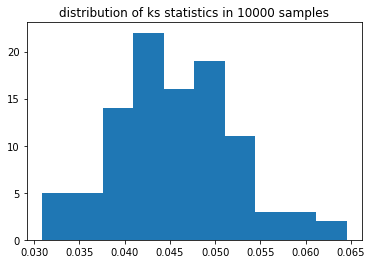

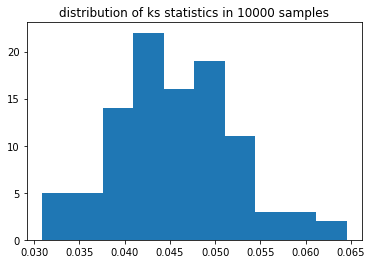

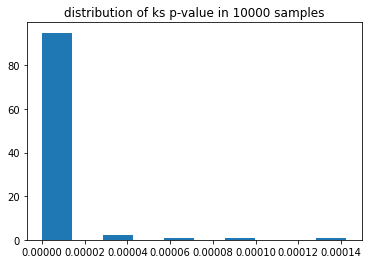

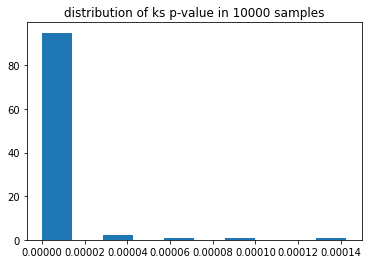

In [ ]:
from scipy.stats import ks_2samp, kstest

sample_count = 10000
d_values = []
p_values = []

d_values2 = []
p_values2 = []

for i in range(100):
    sample1 = np.random.normal(0, 1, sample_count)
    sample2 = np.random.normal(0.1, 1, sample_count)
    p = ks_2samp(sample1,sample2)
    d_values.append(p[0])
    p_values.append(p[1])

    p = ks_2samp2(sample1,sample2)
    d_values2.append(p[0])
    p_values2.append(p[1])

plt.title(f'distribution of ks statistics in {sample_count} samples')
plt.hist(d_values,bins=10)
plt.show()

plt.title(f'distribution of ks statistics in {sample_count} samples')
plt.hist(d_values2,bins=10)
plt.show()

plt.title(f'distribution of ks p-value in {sample_count} samples')
plt.hist(p_values,bins=10)
plt.show()

plt.title(f'distribution of ks p-value in {sample_count} samples')
plt.hist(p_values2,bins=10)
plt.show()

In [ ]:
df_accepted.shape

(1341026, 83)

In [ ]:
pops = []
for i in range(0,len(pop),10000):
    pops.append(pop[i:i+10000])

In [ ]:
len(pops)

135

In [ ]:
sample_drift_mean = []
for i in range(1000):
    # range sampling
    y = random.randint(0,len(pop)-10000)
    #p = ks_2samp(random.sample(pop,10000),pop[y:y+10000])
    p = ks_2samp(pops[0],pop[y:y+10000])
    sample_drift_mean.append(p[0])

In [ ]:
print(np.mean(sample_drift_mean),np.std(sample_drift_mean))

0.08844450000000001 0.01890811174469836


In [ ]:
sample_drift_mean = []
sample_p_value_mean = []
for i in range(4000):
    # range sampling
    y = random.randint(0,len(pops[0])-1000)
    #p = ks_2samp(random.sample(pops[0],1000),pops[0][y:y+1000])
    p = ks_2samp(pops[0],pops[0][y:y+1000])
    sample_drift_mean.append(p[0])
    sample_p_value_mean.append(p[1])

print(np.mean(sample_drift_mean),np.std(sample_drift_mean))
print(np.mean(sample_p_value_mean),np.std(sample_p_value_mean))

0.01646555 0.006795828735150703
0.8719340572626053 0.20264255420113236
